In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv("transactions_patterned.csv")


In [4]:
def engineer_features(df):
    df_fe = df.copy()
    
    df_fe['tran_dt'] = pd.to_datetime(df_fe['tran_dt'])
    
    df_fe['tran_day'] = df_fe['tran_dt'].dt.day
    df_fe['tran_month'] = df_fe['tran_dt'].dt.month
    df_fe['tran_dayofweek'] = df_fe['tran_dt'].dt.dayofweek
    df_fe['tran_is_weekend'] = df_fe['tran_dayofweek'].isin([5, 6]).astype(int)
    
    df_fe['amount_to_balance_ratio'] = df_fe['amount'] / df_fe['sender_prev_bal']
    df_fe['amount_to_balance_ratio'].replace([np.inf, -np.inf], 100, inplace=True)
    df_fe['amount_to_balance_ratio'].fillna(0, inplace=True)
    
    df_fe['amount_exceeds_balance'] = (df_fe['amount'] > df_fe['sender_prev_bal']).astype(int)
    
    sender_stats = df_fe.groupby('sender').agg({
        'amount': ['mean', 'std', 'count', 'max'],
        'sender_prev_bal': ['mean']
    }).reset_index()
    
    sender_stats.columns = ['_'.join(col).strip('_') for col in sender_stats.columns.values]
    
    # Rename columns for clarity
    sender_stats.rename(columns={
        'sender_': 'sender',
        'amount_mean': 'sender_mean_amount',
        'amount_std': 'sender_std_amount',
        'amount_count': 'sender_tx_count',
        'amount_max': 'sender_max_amount',
        'sender_prev_bal_mean': 'sender_mean_balance'
    }, inplace=True)
    
    df_fe = pd.merge(df_fe, sender_stats, on='sender', how='left')
    
    df_fe['sender_std_amount'].fillna(0, inplace=True)
    
 
    df_fe['amount_zscore'] = np.nan
    mask = (df_fe['sender_tx_count'] > 1) & (df_fe['sender_std_amount'] > 0)
    df_fe.loc[mask, 'amount_zscore'] = ((df_fe.loc[mask, 'amount'] - 
                                        df_fe.loc[mask, 'sender_mean_amount']) / 
                                        df_fe.loc[mask, 'sender_std_amount'])
    df_fe['amount_zscore'].fillna(0, inplace=True)
    
    receiver_stats = df_fe.groupby('receiver').agg({
        'amount': ['mean', 'count'],
    }).reset_index()
    
    receiver_stats.columns = ['_'.join(col).strip('_') for col in receiver_stats.columns.values]
    
    receiver_stats.rename(columns={
        'receiver_': 'receiver',
        'amount_mean': 'receiver_mean_amount',
        'amount_count': 'receiver_tx_count'
    }, inplace=True)
    
    df_fe = pd.merge(df_fe, receiver_stats, on='receiver', how='left')
    
    if df_fe['receiver_tx_count'].max() > 0:
        df_fe['receiver_suspicion_score'] = df_fe['receiver_tx_count'] / df_fe['receiver_tx_count'].max()
    else:
        df_fe['receiver_suspicion_score'] = 0
    
    df_fe.drop('tran_dt', axis=1, inplace=True)
    
    return df_fe

df_processed = engineer_features(df)

print("\nFeature-engineered data:")
print(df_processed.head())



Feature-engineered data:
       sender    receiver   amount  sender_prev_bal  tran_day  tran_month  \
0  2301805351  1532644469   147.66          1295.20        20          10   
1  3703962220  2349736332    89.77          9479.55         4           6   
2  1529943053  3465910025   133.80          6677.19         7           2   
3  2555233206  7707731783  1251.02          4546.55        13           6   
4  1761232323  4532052055    55.01          6418.36         3           8   

   tran_dayofweek  tran_is_weekend  amount_to_balance_ratio  \
0               4                0                 0.114006   
1               6                1                 0.009470   
2               1                0                 0.020038   
3               1                0                 0.275158   
4               3                0                 0.008571   

   amount_exceeds_balance  sender_mean_amount  sender_std_amount  \
0                       0          224.650714         210.587837

/tmp/ipykernel_39620/778903555.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_fe['amount_to_balance_ratio'].replace([np.inf, -np.inf], 100, inplace=True)
/tmp/ipykernel_39620/778903555.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].me

In [5]:
features = [
    'amount', 'sender_prev_bal', 'tran_day', 'tran_month', 'tran_dayofweek',
    'tran_is_weekend', 'amount_to_balance_ratio', 'amount_exceeds_balance'
]

sender_receiver_features = [
    'sender_mean_amount', 'sender_std_amount', 'sender_tx_count', 
    'sender_max_amount', 'sender_mean_balance', 'amount_zscore',
    'receiver_mean_amount', 'receiver_tx_count', 'receiver_suspicion_score'
]

for feature in sender_receiver_features:
    if feature in df_processed.columns:
        features.append(feature)

print("\nFeatures used for anomaly detection:")
print(features)
X = df_processed[features].copy()
X.fillna(0, inplace=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Features used for anomaly detection:
['amount', 'sender_prev_bal', 'tran_day', 'tran_month', 'tran_dayofweek', 'tran_is_weekend', 'amount_to_balance_ratio', 'amount_exceeds_balance', 'sender_mean_amount', 'sender_std_amount', 'sender_tx_count', 'sender_max_amount', 'sender_mean_balance', 'amount_zscore', 'receiver_mean_amount', 'receiver_tx_count', 'receiver_suspicion_score']


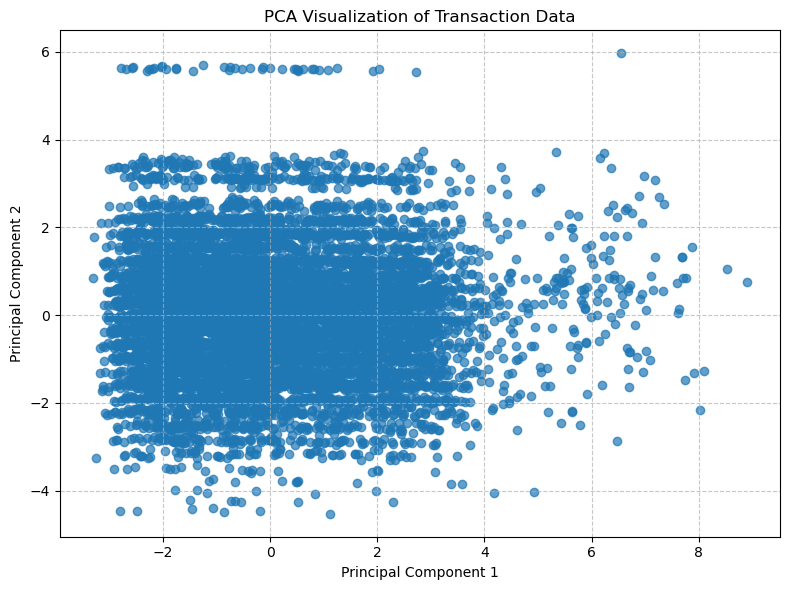

In [6]:
if len(X) >= 3:
    try:
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_scaled)
        
        df_processed['pca1'] = X_pca[:, 0]
        df_processed['pca2'] = X_pca[:, 1]
        
        plt.figure(figsize=(8, 6))
        plt.scatter(df_processed['pca1'], df_processed['pca2'], alpha=0.7)
        plt.title('PCA Visualization of Transaction Data')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
    except:
        print("Not enough variance in data for PCA visualization")
else:
    print("Not enough samples for PCA visualization")


In [8]:
print("\n--- Applying Isolation Forest for Anomaly Detection ---")
contamination = min(0.2, 1/len(X))
iso_forest = IsolationForest(
    n_estimators=100, 
    contamination=contamination,  
    random_state=42,
    bootstrap=True 
)
iso_forest_pred = iso_forest.fit_predict(X_scaled)
df_processed['iso_forest_anomaly'] = (iso_forest_pred == -1).astype(int)
iso_forest_scores = iso_forest.score_samples(X_scaled)
df_processed['iso_forest_score'] = iso_forest_scores
df_processed['iso_forest_anomaly_score'] = 1 - (iso_forest_scores - iso_forest_scores.min()) / (iso_forest_scores.max() - iso_forest_scores.min() or 1) 

print(f"Isolation Forest detected {df_processed['iso_forest_anomaly'].sum()} anomalies out of {len(df_processed)} transactions")



--- Applying Isolation Forest for Anomaly Detection ---
Isolation Forest detected 1 anomalies out of 10000 transactions


In [9]:
results_df = df.copy()
results_df['anomaly_score'] = df_processed['iso_forest_anomaly_score']
results_df['is_anomaly'] = df_processed['iso_forest_anomaly']


In [10]:
conditions = [
    (df_processed['iso_forest_anomaly_score'] < 0.5),
    (df_processed['iso_forest_anomaly_score'] >= 0.5) & (df_processed['iso_forest_anomaly_score'] < 0.8),
    (df_processed['iso_forest_anomaly_score'] >= 0.8)
]
choices = ['low', 'medium', 'high']
results_df['risk_level'] = np.select(conditions, choices, default='unknown')

print(results_df)


         tran_dt      sender    receiver   amount  sender_prev_bal  \
0     2023-10-20  2301805351  1532644469   147.66          1295.20   
1     2023-06-04  3703962220  2349736332    89.77          9479.55   
2     2023-02-07  1529943053  3465910025   133.80          6677.19   
3     2023-06-13  2555233206  7707731783  1251.02          4546.55   
4     2023-08-03  1761232323  4532052055    55.01          6418.36   
...          ...         ...         ...      ...              ...   
9995  2023-06-26  9971126046  6527612750   291.54          9796.93   
9996  2023-02-18  6581131506  6704460197   400.83          2905.65   
9997  2023-04-15  9898976418  3605787210    68.75          4468.60   
9998  2023-08-17  6954377166  8141239801   126.89          1990.84   
9999  2023-05-22  8893138539  4644663335   499.27          9640.94   

      anomaly_score  is_anomaly risk_level  
0          0.398273           0        low  
1          0.378970           0        low  
2          0.277392     

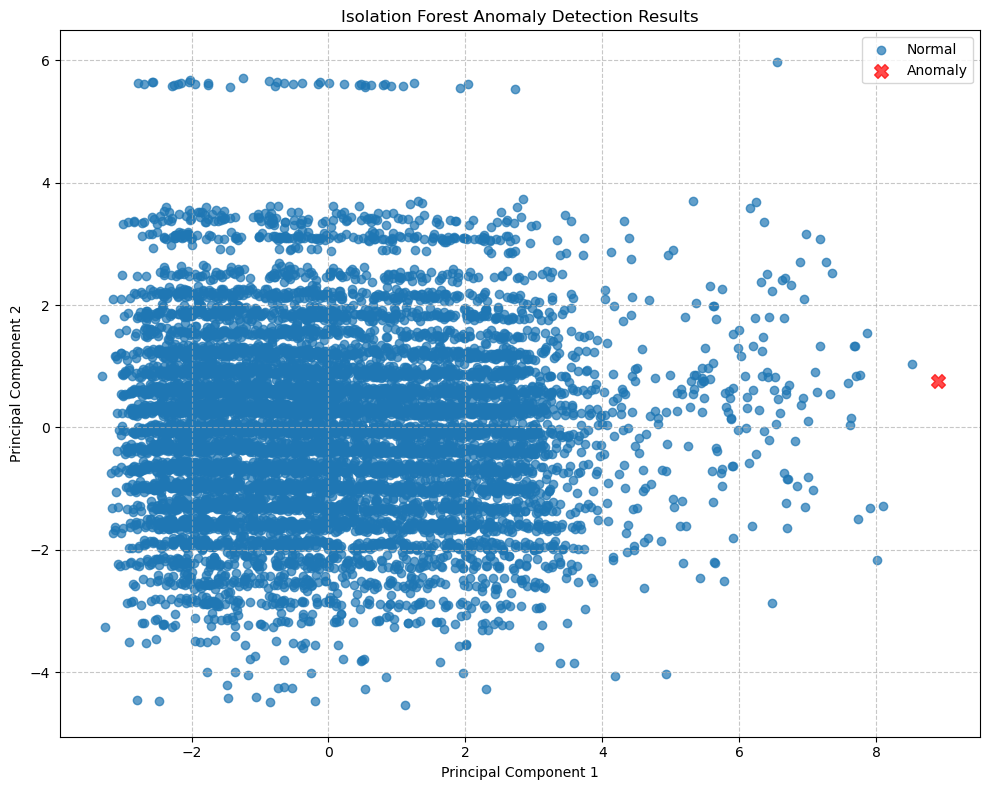

In [11]:
plt.figure(figsize=(10, 8))
plt.scatter(df_processed[df_processed['iso_forest_anomaly'] == 0]['pca1'], 
           df_processed[df_processed['iso_forest_anomaly'] == 0]['pca2'], 
           alpha=0.7, label='Normal')

if df_processed['iso_forest_anomaly'].sum() > 0:
    plt.scatter(df_processed[df_processed['iso_forest_anomaly'] == 1]['pca1'], 
               df_processed[df_processed['iso_forest_anomaly'] == 1]['pca2'], 
               color='red', alpha=0.7, marker='X', s=100, label='Anomaly')

plt.title('Isolation Forest Anomaly Detection Results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
